In [1]:
import tensorflow as tf

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


"""
# Fashion MNIST Classification with ResNet50

This notebook covers:
1. Data loading and exploration
2. Data visualization
3. Model building with HuggingFace ResNet50
4. Training and evaluation
5. Flask app creation for deployment
"""

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.models import Model
from transformers import TFResNetModel, ResNetConfig
from sklearn.metrics import confusion_matrix, classification_report
import os
import json
from PIL import Image
import io

c:\Users\wasif\AppData\Local\pypoetry\Cache\virtualenvs\fmnist-T3Y_rP-5-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## 1. Data Loading and Exploration


In [4]:
# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Number of classes: 10


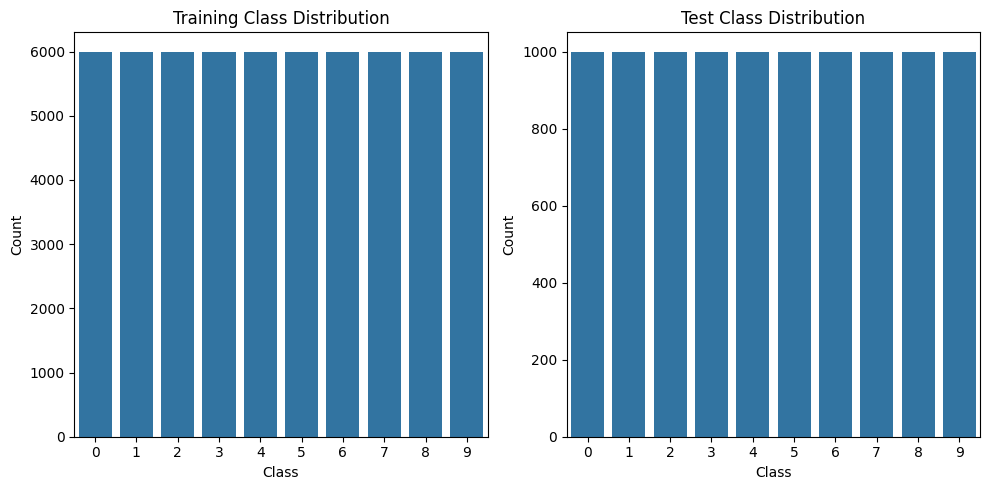

In [5]:
# Basic information about the dataset
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)
print("Number of classes:", len(np.unique(y_train)))

# %%
# Display class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Training Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Test Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 2. Data Visualization

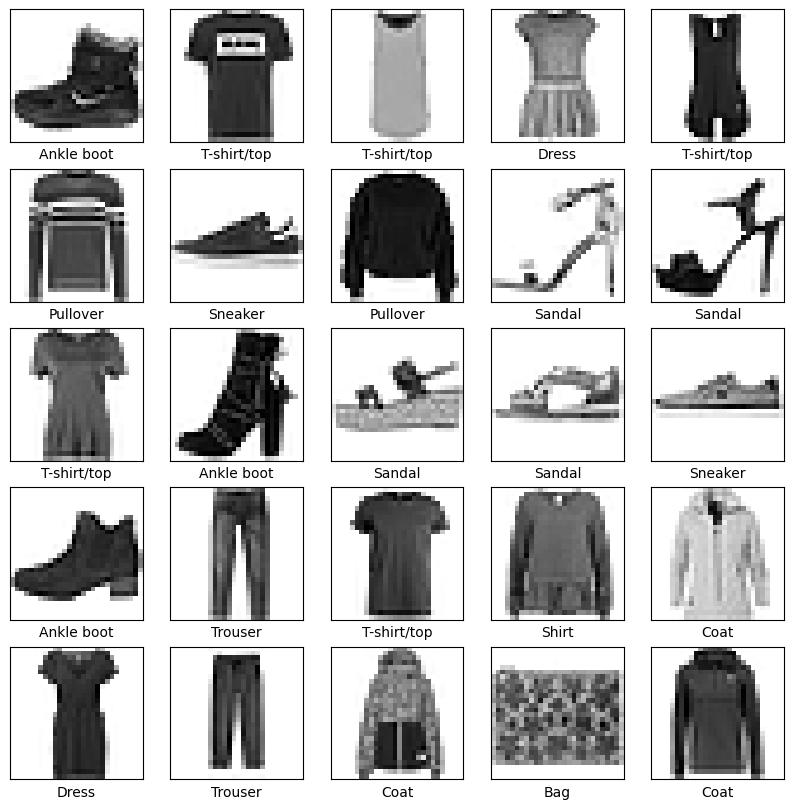

In [6]:
# Display sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

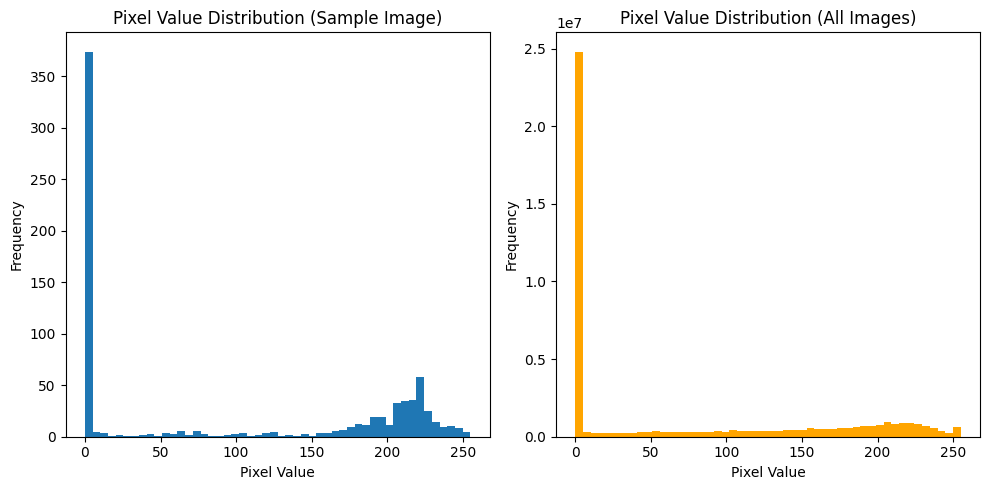

In [7]:
# Pixel value distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(x_train[0].flatten(), bins=50)
plt.title('Pixel Value Distribution (Sample Image)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(x_train.flatten(), bins=50, color='orange')
plt.title('Pixel Value Distribution (All Images)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## 3. Data Preprocessing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.049244784..1.0383226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06289976..1.0427864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0151337385..0.95596004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06983952..0.86615926].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09395554..0.9044054].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035334587..0.9410747].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

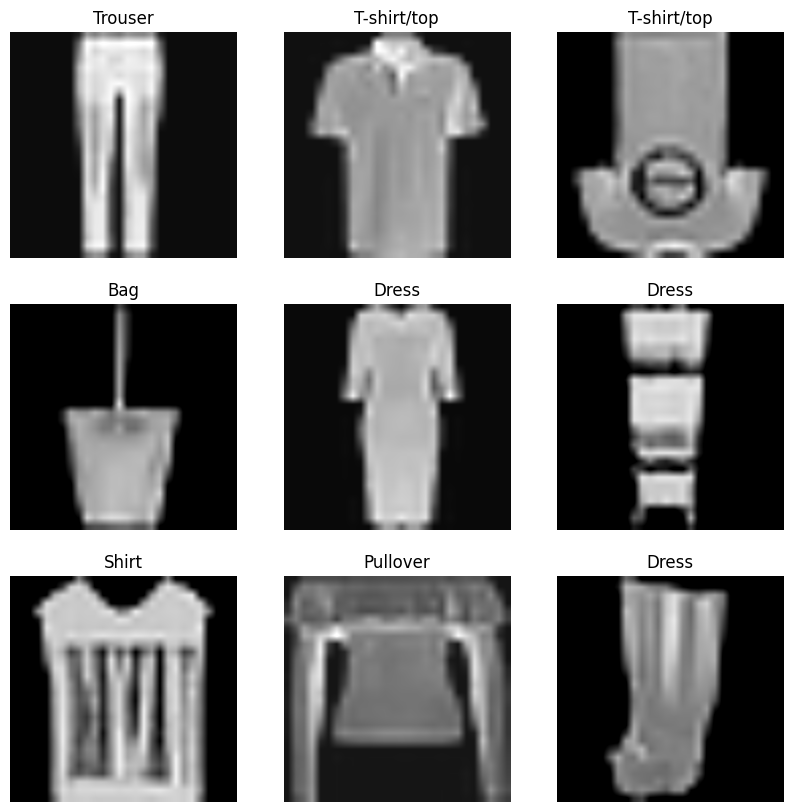

In [11]:
# %%
# Augmented data pipeline
def preprocess(image, label):
    image = tf.expand_dims(image, -1)  # (28, 28, 1)
    image = tf.image.resize(image, [224, 224])  # (224, 224, 1)
    image = tf.image.grayscale_to_rgb(image)  # (224, 224, 3)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment(image, label):
    # Data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Create dataset with augmentation
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(1000) \
    .batch(16) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(16) \
    .prefetch(tf.data.AUTOTUNE)

# %%
# Visualize preprocessed images
sample_images, sample_labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(class_names[sample_labels[i].numpy()])
    plt.axis('off')
plt.show()

## 4. Model Building with ResNet50

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

class InceptionV3FeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._base_model_initialized = False

    def build(self, input_shape):
        if not self._base_model_initialized:
            self.base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
            self.base_model.trainable = False
            self._base_model_initialized = True
        super().build(input_shape)

    def call(self, inputs):
        x = tf.image.resize(inputs, (224, 224))  # Ensure input is resized to (224, 224)
        x = self.base_model(x, training=False)
        return x


# Function to create the custom model with InceptionV3
def create_custom_layer_model():
    inputs = Input(shape=(224, 224, 3))  # Input shape can be 224x224 or any input you want.
    x = InceptionV3FeatureExtractor()(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


# Create and summarize the model
model = create_custom_layer_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3_feature_extrac  (None, 5, 5, 2048)       21802784  
 tor_1 (InceptionV3FeatureEx                                     
 tractor)                                                        
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                           

## 5. Model Training

In [13]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)

Epoch 1/15
3750/3750 [==============================] - 175s 45ms/step - loss: 0.5102 - accuracy: 0.8150 - val_loss: 0.4623 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 2/15
3750/3750 [==============================] - 170s 45ms/step - loss: 0.4103 - accuracy: 0.8515 - val_loss: 0.4096 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 3/15
3750/3750 [==============================] - 168s 45ms/step - loss: 0.3797 - accuracy: 0.8618 - val_loss: 0.3927 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 4/15
3750/3750 [==============================] - 166s 44ms/step - loss: 0.3605 - accuracy: 0.8679 - val_loss: 0.3953 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 5/15
3750/3750 [==============================] - 166s 44ms/step - loss: 0.3444 - accuracy: 0.8729 - val_loss: 0.4085 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 6/15
3750/3750 [==============================] - 166s 44ms/step - loss: 0.2912 - accuracy: 0.8938 - val_loss: 0.3452 - val_accuracy: 0.8757 - lr: 1.0000e-04
Epoch 7/15
3750/3750 [==============

## 6. Model Evaluation

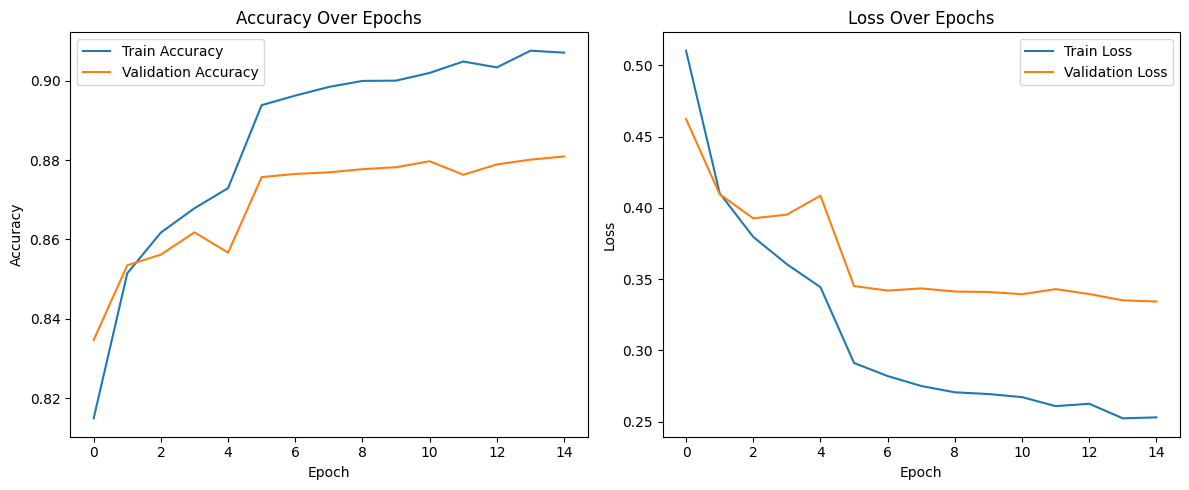

In [14]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

625/625 [==============================] - 24s 37ms/step - loss: 0.3343 - accuracy: 0.8809

Test Accuracy: 0.8809
Test Loss: 0.3343
625/625 [==============================] - 23s 35ms/step


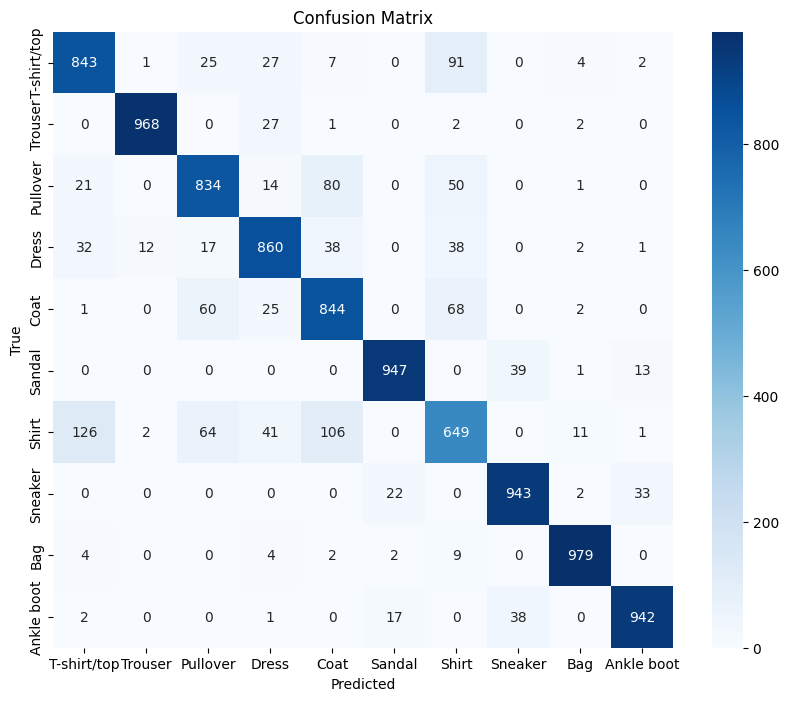


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.84      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.83      0.83      0.83      1000
       Dress       0.86      0.86      0.86      1000
        Coat       0.78      0.84      0.81      1000
      Sandal       0.96      0.95      0.95      1000
       Shirt       0.72      0.65      0.68      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [15]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# %%
# Generate predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# %%
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


## 7. Save test iamges locally to upload on flask app

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Take first 5 test images
sample_images = x_test[:5]
sample_labels = y_test[:5]

# Create directory to save images
output_dir = 'fashion_mnist_samples'
os.makedirs(output_dir, exist_ok=True)

# Class names (only for filename, not inside image)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Save each image without adding label in the image
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='gray')  # preserve original grayscale
    plt.axis('off')  # remove axes, ticks, grid, labels
    filename = f"{i}_{class_names[label]}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"Saved: {filepath}")

print(f"\nAll {len(sample_images)} images saved without label overlays to '{output_dir}'")


Saved: fashion_mnist_samples\0_Ankle boot.png
Saved: fashion_mnist_samples\1_Pullover.png
Saved: fashion_mnist_samples\2_Trouser.png
Saved: fashion_mnist_samples\3_Trouser.png
Saved: fashion_mnist_samples\4_Shirt.png

All 5 images saved without label overlays to 'fashion_mnist_samples'


## 7. Save Model and Create Flask App

In [24]:
import os
import json
from tensorflow.keras.models import save_model

# Define the path to the artifacts folder (outside current notebook directory)
artifacts_dir = os.path.join("..", "artifacts")  # Goes up one level from the notebook
os.makedirs(artifacts_dir, exist_ok=True)

# Save the model
model_path = os.path.join(artifacts_dir, "fashion_mnist_inception.h5")
model.save(model_path, save_format="h5")  # Saves in HDF5 format

# Save class names
class_names_path = os.path.join(artifacts_dir, "class_names.json")
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)

print(f"Model saved to: {model_path}")
print(f"Class names saved to: {class_names_path}")

Model saved to: ..\artifacts\fashion_mnist_inception.h5
Class names saved to: ..\artifacts\class_names.json
